In [1]:
import sys
import os.path as op
import os
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')

from netmap.src.utils.netmap_config import NetmapConfig
from src.methods.csnet.csnet_config import CsNetConfig
from src.data_simulation.data_simulation_config import DataSimulationConfig
from src.pipelines.utils import PipelineConfig
from captum.attr import GradientShap


import anndata
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
import scipy.sparse as scs
from sklearn.cluster import SpectralClustering

from src.utils import write_config

import numpy as np
import pandas as pd
from typing import Optional
import itertools
import warnings


In [2]:
from netmap.src.downstream.downstream import *
from netmap.src.downstream.edge_selection import *

In [3]:
dataset_config = "/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_three/net_84_806_net_88_872_net_90_941_net_60_657.config.yaml"
netmap_config = '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_84_806_net_88_872_net_90_941_net_60_657/config.yaml'
dataset_config =DataSimulationConfig.read_yaml(dataset_config)

config_dict = {}
config_dict['config_4'] = NetmapConfig.read_yaml(netmap_config)
c = 'config_4'
grn_adata =  sc.read_h5ad(op.join(config_dict[c].output_directory, config_dict[c].adata_filename))
ref_adata = sc.read_h5ad(config_dict[c].input_data)





{'input_data': '/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_three/net_84_806_net_88_872_net_90_941_net_60_657/data.h5ad', 'layer': 'X', 'output_directory': '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_84_806_net_88_872_net_90_941_net_60_657', 'transcription_factors': '/data_nfs/datasets/SCENIC_DB/tf_lists/allTFs_hg38.txt', 'tf_only': False, 'penalize_error': True, 'adata_filename': 'grn_lrp.h5ad', 'grn': 'grn_lrp.tsv', 'masking_percentage': 0.1, 'print_every': 100, 'optimizer': 'Adam', 'learning_rate': 0.005, 'epochs': 10000, 'n_models': 10, 'validation_size': 0.2, 'model': 'ZINBAutoencoder', 'xai_method': 'GuidedBackprop', 'aggregation_strategy': 'mean'}


In [5]:
grn_adata = add_top_edge_annotation_global(grn_adata, top_edges=[0.2], nan_fill=0)

[0.2]


In [10]:
grn_adata.var

,source,target,global_cell_count_0.2,n_cells,cell_count_0.1_1,cell_count_0.1_2,cell_count_0.1_0
edge_key,,,,,,,
ACACB_ACACB,ACACB,ACACB,1364.0,1498,575.0,0.0,219.0
ACACB_ACAN,ACACB,ACAN,509.0,1500,0.0,0.0,0.0
ACACB_ACTA2,ACACB,ACTA2,314.0,220,0.0,0.0,0.0
ACACB_ADAM19,ACACB,ADAM19,344.0,1500,0.0,0.0,401.0
ACACB_ADAMTS5,ACACB,ADAMTS5,478.0,1500,541.0,0.0,500.0
...,...,...,...,...,...,...,...
hsa-miR-381-3p_ZNF384,hsa-miR-381-3p,ZNF384,498.0,1463,0.0,0.0,0.0
hsa-miR-381-3p_ZNF652,hsa-miR-381-3p,ZNF652,499.0,776,0.0,0.0,0.0
hsa-miR-381-3p_hsa-miR-205-5p,hsa-miR-381-3p,hsa-miR-205-5p,800.0,1097,0.0,0.0,0.0


In [6]:
# preprocess GRN anndata object
grn_adata = process(grn_adata=grn_adata[:, grn_adata.var['global_cell_count_0.2']>0].copy(), n_clu=3)

/data_nfs/og86asub/netmap/netmap-evaluation/netmap/src/downstream/downstream.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=config['leiden_resolution'])


clustering: 3 clusters


/data_nfs/og86asub/netmap/netmap-evaluation/netmap/.pixi/envs/default/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [7]:
grn_adata = add_top_edge_annotation_cluster(grn_adata)

[0.1]
[0.1]
[0.1]


In [9]:
grn_adata.var

,source,target,global_cell_count_0.2,n_cells,cell_count_0.1_1,cell_count_0.1_2,cell_count_0.1_0
edge_key,,,,,,,
ACACB_ACACB,ACACB,ACACB,1364.0,1498,575.0,0.0,219.0
ACACB_ACAN,ACACB,ACAN,509.0,1500,0.0,0.0,0.0
ACACB_ACTA2,ACACB,ACTA2,314.0,220,0.0,0.0,0.0
ACACB_ADAM19,ACACB,ADAM19,344.0,1500,0.0,0.0,401.0
ACACB_ADAMTS5,ACACB,ADAMTS5,478.0,1500,541.0,0.0,500.0
...,...,...,...,...,...,...,...
hsa-miR-381-3p_ZNF384,hsa-miR-381-3p,ZNF384,498.0,1463,0.0,0.0,0.0
hsa-miR-381-3p_ZNF652,hsa-miR-381-3p,ZNF652,499.0,776,0.0,0.0,0.0
hsa-miR-381-3p_hsa-miR-205-5p,hsa-miR-381-3p,hsa-miR-205-5p,800.0,1097,0.0,0.0,0.0


In [ ]:
grn_adata.obs['grn'] = pd.Categorical(ref_adata.obs['grn'])

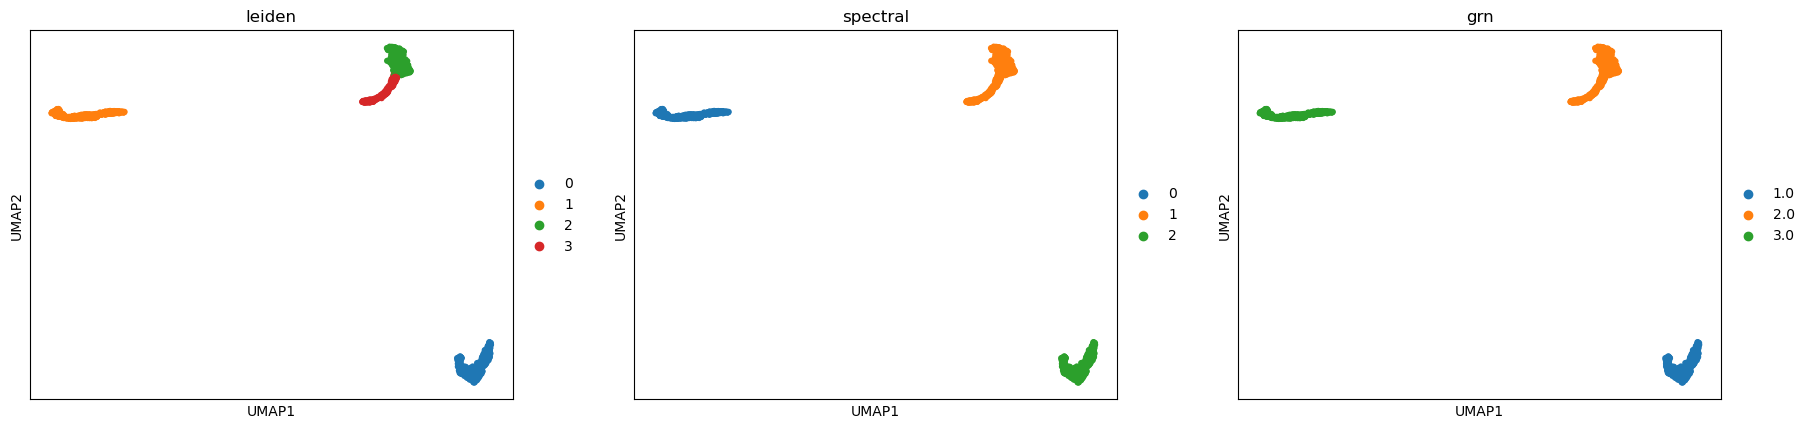

In [ ]:
sc.pl.umap(grn_adata, color = ['leiden', 'spectral', 'grn'])